## Basics of Computer Vision

This is a short introduction in some basic elements of computer vision. We will deal with representation of an image inside a computer, introduce convolutional operations and present how to use them to transform an image to extract information.

Finally, These steps are there to develop some intuition for the lead up to deep convolutional neural networks that make up most of the modern hype. We won't go deep into the math behind neural networks, but rather try to explain what do they do to analyze images.

**There is no prerequisite knowledge required** for this workshop, other than being able to execute cells in this notebook. For an example how to get that to work refer to Anaconda setup.

#### Packages

Python imports packages that provide existing implemntations for many useful things. If you fail to import a package, install it into your python environment and re-run the cell.

Here we have the first 3 important packages for this workshop

cv2 - https://opencv.org/ a collection of tools for computer vision and image processing

matplotlib - a library used to create displays, graphs, plots, etc.

numpy - a library that provides feature rich matrix algebra support

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#### Lenna

[Lenna](https://en.wikipedia.org/wiki/Lenna) is a famous picture in image processing with interesting stories related to it.

Below we first read in the image. When working with images, we use a 3D matrix representation for them. They have width, height and a number of "channels" which may correspond to various things but RED, GREEN and BLUE are the most well known. 

In [2]:
lenna = cv2.imread('Lenna.png')
print(lenna.shape)
# [:3, :3, :] is interpreted, first three of first dimension, first three of second dimension, all of third dimension
# Python is zero-indexed, so the RGB of the first row, first column would be [0, 0, :], or more explicit [0, 0, 0:3]
# 0:3 means "0, 1, 2", as 3, the upper bound is excluded.
# This can also be written as [:3][:3][:] where you select parts of each dimension at time
lenna[:3, :3, :]

(512, 512, 3)


array([[[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223]],

       [[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223]],

       [[125, 137, 226],
        [125, 137, 226],
        [133, 137, 223]]], dtype=uint8)

As you can see, _lenna_ is a matrix of shape 512 x 512 x 3, with values in 0-255 range that present corresponding color intensity at that pixel location. Only top left 3 x 3 x 3 piece of the matrix is printed out to save space, but observe that there are 3 groups of 3 lists with 3 values each.

OpenCV reads in images with Blue Green Red order of color channels, but most other tools work with Red Green Blue, so we are going to convert colors (cvtColor) to that order. This is as simple as reordering of elements but there are many other color models, such as Grayscale or CMYK.

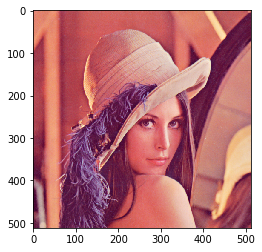

In [3]:
lenna = cv2.cvtColor(lenna, cv2.COLOR_BGR2RGB)

plt.imshow(lenna)
plt.show()

The XY axis are added in by matplotlib by default, and not part of the image.

Lets discuss channels more. RGB color model is so commonly know since display monitors have a source of red, green and blue lights at each pixel location, and mix those colors to generate a display. As such this color model is oriented towards display and often does not really tell us interesting thigs about the image.

In fact, we can split the image into the R G and B components, but that on its own does not let us learn much more about the image.

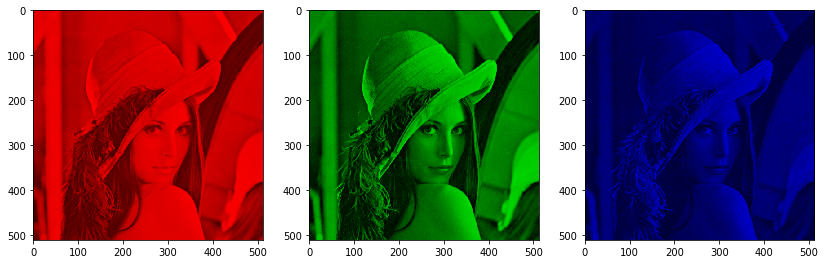

In [4]:
# For each color component we copy the original image and set the remaining components to 0
# [:, ...] style of selection is a feature provided by numpy and will not work with Python lists
# [:, :, [1, 2]] is interpreted as: entire first dimension, entire second dimension, second and third parts of third dimension
# After we select the Green and Blue channel, we set all values in those to 0
R = np.copy(lenna)
R[:,:, [1, 2]] = 0
G = np.copy(lenna)
G[:,:, [0, 2]] = 0
B = np.copy(lenna)
B[:,:, [0, 1]] = 0

# matplotlib's plots for drawing are called axes
f, ax = plt.subplots(1, 3, figsize=(14, 8))
ax[0].imshow(R)
ax[1].imshow(G)
ax[2].imshow(B)
plt.show()

If these three images would be layered on top of each other, we get the original image.

However, presenting the R G B components in their actual color is not really meaningful, since once they are split appart they are simply channels containing intensities at pixel locations. So we will present them as such, note the "vmin=0, vmax=255" with fixes the range of values. *matplotlib* adjusts display intensity bounds to the minimal and maximal value encountered, which is useful for presenting image-like content that are simply intensities, maybe in 0.0-1.0 scale, unrelated to 0-255 pixel value range.

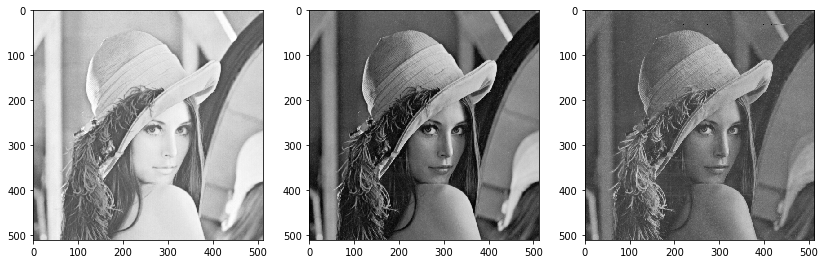

In [5]:
f, ax = plt.subplots(1, 3, figsize=(14, 8))
for i in range(3):
    # We select 
    ax[i].imshow(lenna[:,:,i], cmap='gray', vmin=0, vmax=255)

Note that if we have only intensities, we can use any color map of choice to present them: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

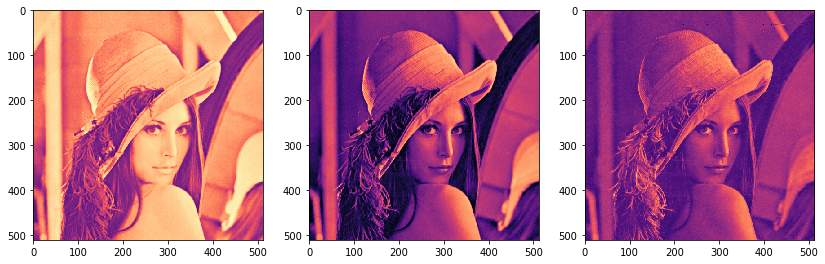

In [6]:
f, ax = plt.subplots(1, 3, figsize=(14, 8))
for i in range(3):
    ax[i].imshow(lenna[:,:,i], cmap='magma', vmin=0, vmax=255)

### Torch

[PyTorch](https://pytorch.org/) is a library used for tensor algebra and machine learning based, mostly based on gradient optimization. If you are a beginner to all this stuff, it will be overwhelming so just focus on what is going on rather than how its used.

Below we first convert RGB lenna image to grayscale, then cast it to a torch tensor. A tensor is something like a matrix, but it has an arbitrary number of dimensions, and it also uses torch implemntation that adds various functionalities.
First of those is unsqueeze, which adds a dimension.

So lets take this slow, conversion to grayscale will convert the 512x512x3 image to 512x512. Since in grayscale there is only one channel the third dimension is not needed, but note that 512x512 and 512x512x1 are mechanically different things, even though the content is the same.

The unsqueeze operation adds these "unneeded" dimensions, so .unsqueeze(0) will add a single element dimension as the first dimension, i.e. 512x512 will become 1 x 1 x 512 x 512. This is important for how torch operations work on data.

First of all, a lot of torch functions expect the first dimension to be "batch" dimension, i.e. they will work on a number of images at once. Secondly, OpenCV uses "height x width x channels" order of dimensions for an image, while torch uses "channels x height x width". The second "unneeded" dimensions is a stand in for channels.

If this is confusing, just don't mind it.

In [7]:
import torch
import torch.nn.functional as F

img = torch.tensor(cv2.cvtColor(lenna, cv2.COLOR_RGB2GRAY)).unsqueeze(0).unsqueeze(0)

### Convolution

We will use torch to perform convolution operations. Convolution is one of the most important operations in signal analysis, and a image can be thought of as a collection of 2-dimensional (discrete) signals (each channel is a separate signal).
But that is also not that important.

In this context all you need to know about convolution is that there exist a "kernel" which is aplied in a sliding manner over the image as presented on the animation.

The kernel takes an image, and for a neighbourhood of pixels calculates a new value for that location.

![convolution](./full_padding_no_strides_transposed.gif "convolution")

from: [github.com/vdumoulin/conv_arithmetic](https://github.com/vdumoulin/conv_arithmetic)

This would be better explained with an example.
If we have a image channel with these values:

```
ABCD
EFGH
IJKL
```

and we convolve it with ` [-1 +1] `, we would get:
```
-1*A+1*B -1*B+1*C -1*C+1*D
-1*E+1*F -1*F+1*G -1*G+1*H
-1*I+1*J -1*J+1*K -1*K+1*L
```

Below we shall convolve the grayscale lenna image with:
```
-1 +1
```
and
```
 -1
 +1
```

The second kernel is a transposition of the first one.

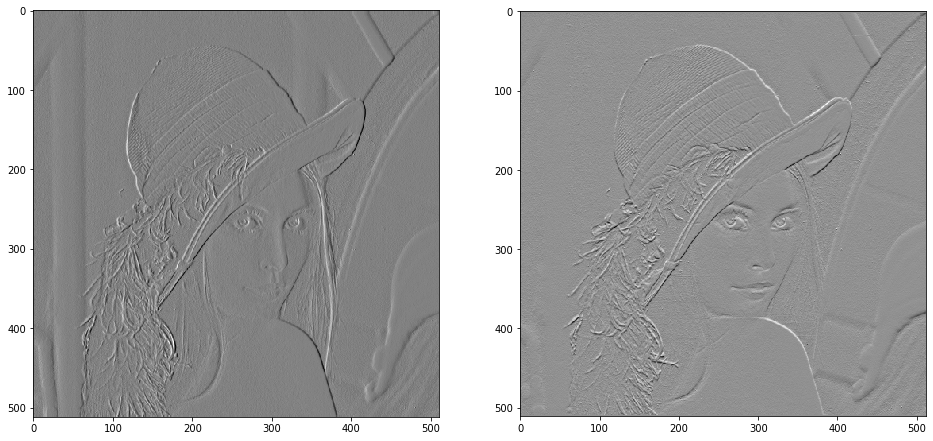

In [8]:
kernel = np.array([[-1, 1]])

kernels = [kernel, kernel.T]

f, ax = plt.subplots(1, 2, figsize=(16, 10))
lennas = []
for i, k in enumerate(kernels):
    grad_lr = torch.tensor(k).reshape(1, 1, *k.shape)

    gimg = F.conv2d(img.float(), grad_lr.float())
    
    # We remove the batch and channel dimension for displaying the result
    ax[i].imshow(gimg[0][0], cmap='gray')
    # Store the absolute value of the gradient for later
    lennas.append(gimg[0][0][:511, :511].abs())
plt.show()

What we got are the horizontal and vertical "gradient" of the image. Observe that some outlines are very visible in these images.

If we average the absolute value of both gradients we can get the outlines of fine details in the image.
In the context of signal processing these would be the high frequencies present in the image.

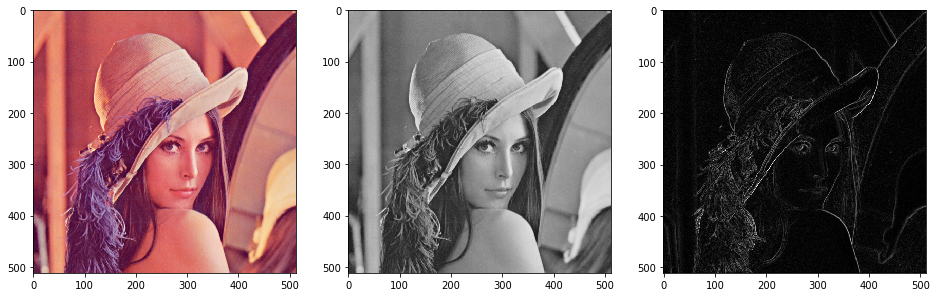

In [9]:
f, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(lenna)
ax[1].imshow(img[0][0], cmap='gray', vmin=0, vmax=255)
ax[2].imshow(sum(lennas) / 2, cmap='gray')
lenna_l1 = sum(lennas) / 2
plt.show()

We can also get the more rough outlines by using a "wider" convolution kernel.

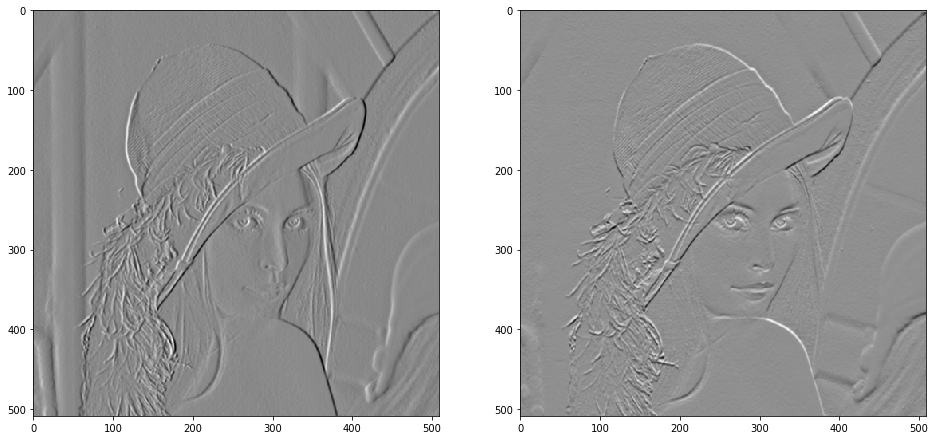

In [10]:
kernel = np.array([[0, 0, 0, 0],
                   [-1, -1, 1, 1],
                   [-1, -1, 1, 1],
                   [0, 0, 0, 0]])
kernels = [kernel, kernel.T]

f, ax = plt.subplots(1, 2, figsize=(16, 10))
lennas = []
for i, k in enumerate(kernels):
    grad_lr = torch.tensor(k).reshape(1, 1, *k.shape)

    gimg = F.conv2d(img.float(), grad_lr.float())
    ax[i].imshow(gimg[0][0], cmap='gray')
    lennas.append(gimg[0][0].abs() / 4)
plt.show()

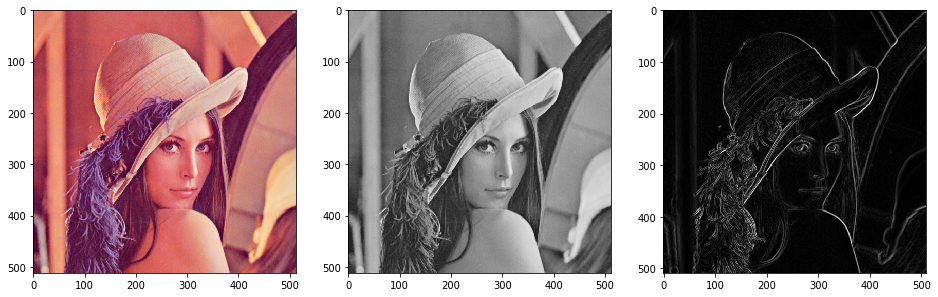

In [11]:
f, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(lenna)
ax[1].imshow(img[0][0], cmap='gray', vmin=0, vmax=255)
ax[2].imshow(sum(lennas) / 2, cmap='gray')
lenna_l2 = sum(lennas) / 2
plt.show()

Notice that as the kernel takes in more of the surrounding pixels, it captures rougher details.

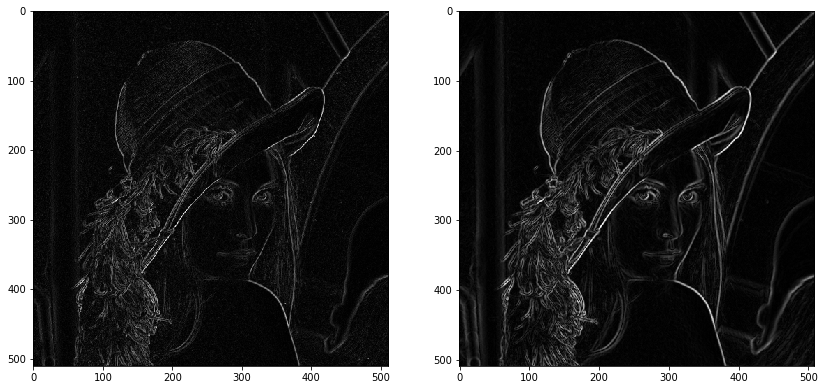

In [12]:
f, ax = plt.subplots(1, 2, figsize=(14, 10))
ax[0].imshow(lenna_l1, cmap='gray')
ax[1].imshow(lenna_l2, cmap='gray')
plt.show()

#### Image scale

The fine/rough details, outlines, high and low frequencies present in the image introduce the concept of "scale".

Above we doubled the size of convolution kernel to get rougher transitions in the image, but the same effect would be achieved by halving the image resolution, as the relative area of the kernel would stay the same.

Reducing the image resolution, or zooming-out, allows our various operations to operate at different image scales. Scale would be a "depth" to the image width and height, and splitting it across scales would be interesting for image analysis. However, halving the image resolution would give very few scales, thankfully we can use Gaussian blur to get finer scales.

#### Gaussian blur

We perform Gaussian blur by once again convolving the image with a kernel containing valued of probability density functuion of Gaussian distribution. That is a mouthfull, but the important part is that values of near the center of the kernel are greater than ones near the edge, and they all sum up to `1`.

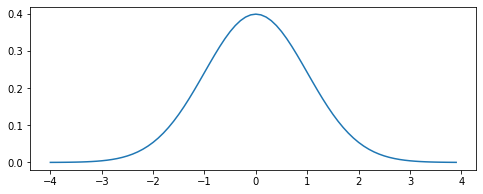

In [13]:
mean, variance = (0, 1)
x = np.arange(-4, 4, 0.1)
y = np.exp(-np.square(x - mean) / (2 * variance)) / (np.sqrt(2 * np.pi * variance))

plt.figure(figsize=(8, 3))
plt.plot(x, y)
plt.show()

OpenCV thanfully can generate such kernels of desired size for us.

In [14]:
gauss_kernel = cv2.getGaussianKernel(5, -1)
print(gauss_kernel.T, gauss_kernel.sum())
print()
gauss2d_kernel = gauss_kernel * gauss_kernel.T
print(gauss2d_kernel, gauss2d_kernel.sum())

[[0.0625 0.25   0.375  0.25   0.0625]] 1.0

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]] 1.0


Using the Gaussian kernel we blur the image N times, slowly going up the scale. In most applications after a few blurs the image resolution is also halved but I skip that step here.

Below you can observe how the image slowly loses its finer details. We do save the image at each step of bluring for the next part.

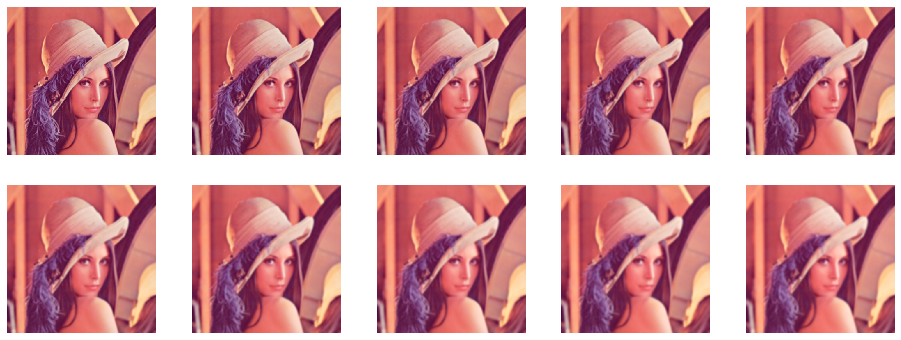

In [15]:
gauss_lenna = [lenna]
for i in range(10):
    gauss_lenna.append(cv2.GaussianBlur(gauss_lenna[-1], (5, 5), cv2.BORDER_REPLICATE))

f, ax = plt.subplots(2, 5, figsize=(16,6))
for i in range(10):
    ax[i//5][i%5].imshow(gauss_lenna[i+1])
    ax[i//5][i%5].set_axis_off()
plt.show()

Now we shall do something exciting. If X is the original image, and X' is the image after one step of blurring, then we can calculate:
```
X - X' = dX
X' - X'' = dX'
...
```
observe that:
```
X'''' + dX''' + dX'' + dX' + dX = X
```

Just like with R G B split images that could be overlayed to get the original image, this differences of Gaussian blurs can also be added up to the final blurred image to reconstruct the original.

I.e., instead of splitting image to the color channels, we can split it to _scale_ channels, wherein each channel will have details for that scale, neat.

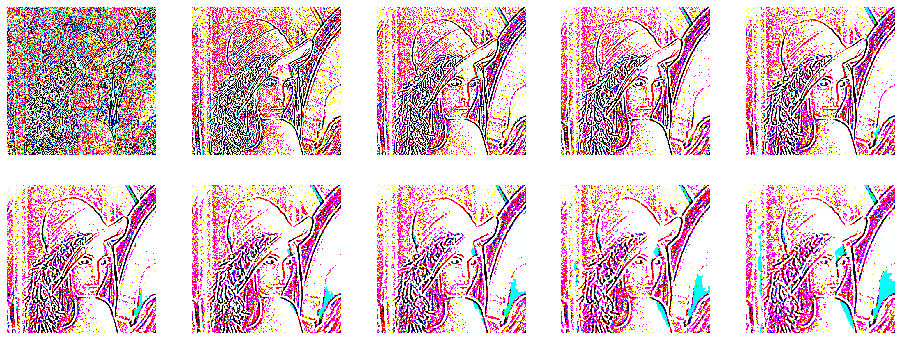

In [16]:
f, ax = plt.subplots(2, 5, figsize=(16, 6))
diff_lenna = []
for i in range(10):
    diff_lenna.append(gauss_lenna[i] - gauss_lenna[i+1])
    ax[i//5][i%5].imshow(diff_lenna[-1])
    ax[i//5][i%5].set_axis_off()
plt.show()

Below we add all the differences, and then add them to the final blurred image, reproducing the original.

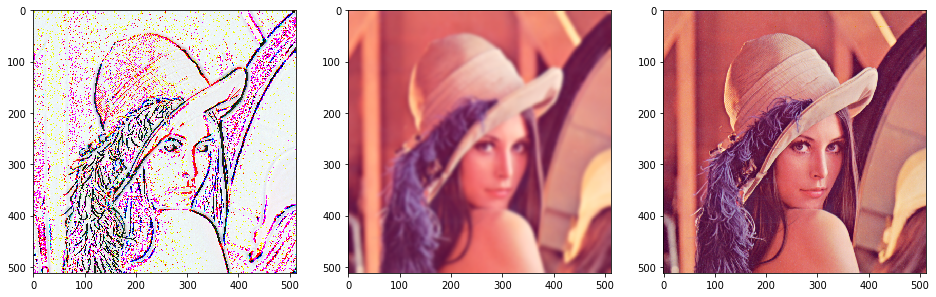

In [17]:
f, ax = plt.subplots(1, 3, figsize=(16,10))
ax[0].imshow(sum(diff_lenna))
ax[1].imshow(gauss_lenna[-1])
ax[2].imshow(gauss_lenna[-1] + sum(diff_lenna))
plt.show()

This is the same proces, but just for much more blur steps.

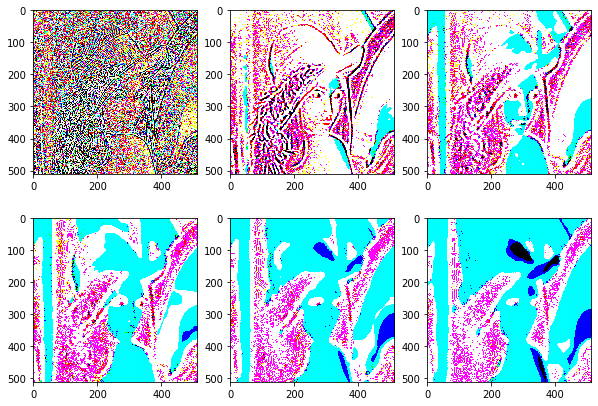

In [18]:
gauss_lenna = lenna.copy()
diff_lenna = None
diffs = []
for i in range(50):
    blur_lenna = cv2.GaussianBlur(gauss_lenna, (5, 5), cv2.BORDER_REPLICATE)
    diff_lenna = gauss_lenna - blur_lenna
    gauss_lenna = blur_lenna
    if i % 9 == 0:
        diffs.append(diff_lenna)

f, ax = plt.subplots(2, 3, figsize=(10,7))
for i, d in enumerate(diffs):
    ax[i // 3][i % 3].imshow(d)
plt.show()

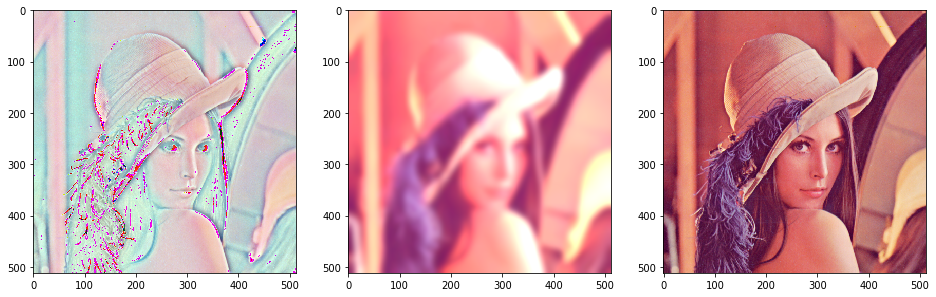

In [19]:
gauss_lenna = lenna.copy()
diff_lenna = None
for i in range(50):
    blur_lenna = cv2.GaussianBlur(gauss_lenna, (5, 5), cv2.BORDER_REPLICATE)
    diff_lenna = gauss_lenna - blur_lenna
    gauss_lenna = blur_lenna
f, ax = plt.subplots(1, 3, figsize=(16,10))
ax[0].imshow(lenna - gauss_lenna)
ax[1].imshow(gauss_lenna)
ax[2].imshow(lenna)
plt.show()

### Segmentation

This is a bit of a detour from above, but using the properties of "borders" in the image that could be observed above, there are also algorithms for segmenting the image into "regions". The goal of this is to simpy say that a piece of an image is one connected "segment". Today we have and advanced form of this segmentation called "Semantic segmentation" that aims to segment the image into parts with the same "meaning", i.e. buildings, road, vegetation, sky, people...

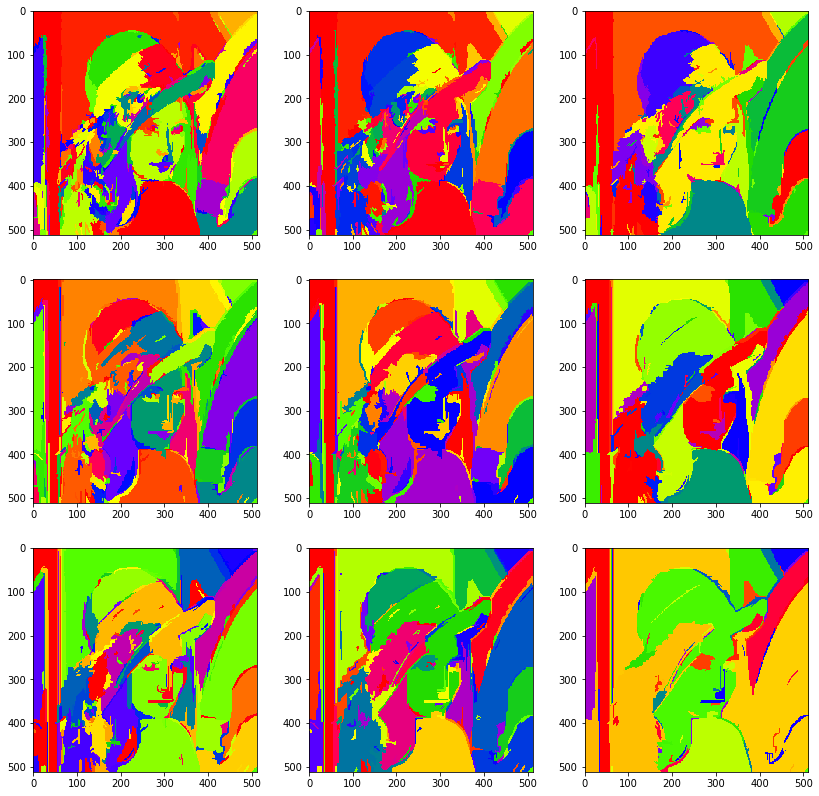

In [20]:
f, ax = plt.subplots(3, 3, figsize=(14,14))
for i, sigma in enumerate([0.5, 0.8, 1.2]):
    for j, k in enumerate([200, 300, 500]):
        gs = cv2.ximgproc.segmentation.createGraphSegmentation(sigma=sigma, k=k, min_size=50)
        lenna_segmented = gs.processImage(lenna)
        ax[i][j].imshow(lenna_segmented, cmap='prism')
plt.show()

Note that this sementation s a mask, that once again allows as to split the original image into "channels".

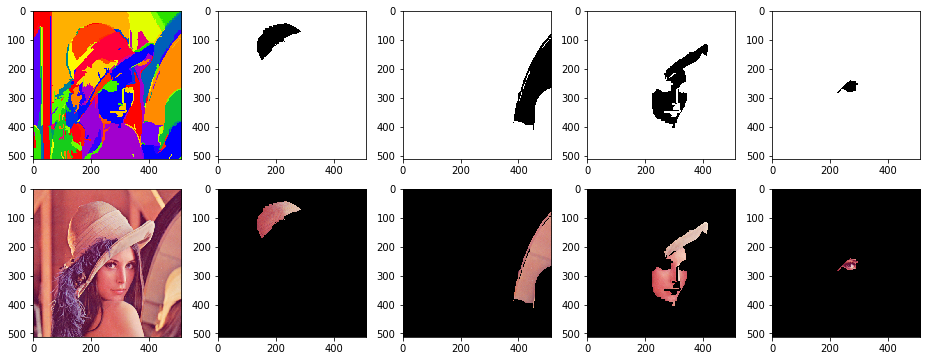

In [21]:
gs = cv2.ximgproc.segmentation.createGraphSegmentation(sigma=0.8, k=300, min_size=50)
lenna_segmented = gs.processImage(lenna)
f, ax = plt.subplots(2, 5, figsize=(16,6))
k = 75
ax[0][0].imshow(lenna_segmented, cmap='prism')
ax[1][0].imshow(lenna)
for i, s in enumerate([19, 37, 46, 76]):
    m = lenna_segmented==s
    sm = lenna_segmented.copy()
    sm[~m] = 0
    lm = lenna.copy()
    lm[~m] = 0
    ax[0][i+1].imshow(sm, cmap='binary')
    ax[1][i+1].imshow(lm)
plt.show()

### Convolutional Neural Networks

The workshop so far should have explained several important concepts: convolution operations on an image, image "scale", and the idea that we can split the image into "meaningful" channels.

Now we shall look at convolutional neural networks, and try to reason about what they do.

#### Training neural networks...
... shall be covered most briefly. This is too big a topic for this workshop. At this point all you need to now is that neural networks are parametric models, with parameters being for example values in kernels. Those values are set using some method so that the overall network does something meaningful, for example say what object is in the image.

If we were to train a model for classification, then we would have a set of images <b>X</b>, with labels <b>y</b> for each image, and a model which contains a set of values what can be changed <b>w</b> called parameters. The model outputs a score for each output class, and with a bit of math we can convert those scores so each is on 0.0-1.0 range and they all sum up to 1.0, so they are a bit like probability for each class.

Model is trained so the weights w are set to values that maximize the product of `P(y|X, w)` of all images. Given images and their labels an optimization algorithms does that for us, we don't know the reasoning behind each separate value but we do know what was the goal it tried to achieve.

![lenet5](./lenet5.png "lenet5")

LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.

Before we applied a simple kernel on a single channel "image" for simplicity, but we can also apply a N-channel kernel on a N-channel "image". The logic remains the same, except we have a set of values for each channel, and we sum everything up in the end. For example, for an RGB image with 3 channels, we would use a kernel with 3 channels, but if we say split the image into differences of gaussian blur with 9 differences and the final blur for a total of 10 channels, we could use a 10 channel kernel to perform an operation over all channels. The convolution operation is applied over spatial dimensions and generally affects all channel values at a location.

Now, for an RGB image we can have a 3x3x3 kernel, and that kernel will produce an output "image", commonly called output channel or output map. If we had 10 such kernels we would have 10 output channels, and each channel could be reserved for a different kind of information.

If you observe the neural network architecture in the image above, you can observe that the general sequence is:
1. Convolution with k kernels
2. Reduction of resolution by half (pooling operation, a form of downsampling)
3. Convolution with 2 * k kernels

This process does great many things, some of them related to computing efficiency not important right now. Observe the repeated use of convoutions, on various scales due to reduction of resolution, and that how the amount of spatial relevant information so increases the amount of channels which could hold some specific kind of information.

There is a great variety of architectures for such networks, but the one common element is the repeated use of convolutional "layers".

We shall look at what happens with a similar model, thankfully, torch provides an easy way to get popular already trained models.

We shall use ResNet18, a model trained to predict which of a 1000 classes is present on the image.

He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

In [22]:
import torchvision

# We use the RGB lenna image this time, so we need to move the color dimension to the second place.
img = torch.tensor(lenna).permute(2, 0, 1)
# Torch, and neural networks in general don't like 0-255 pixel values.
img = img.float() / 255
# They also don't like 0-1.0 range, so they normalize its average value and variance 
#normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#img = normalize(img)
# Now we add the batch dimension
img = img.unsqueeze(0)

In [23]:
resnet18 = torchvision.models.resnet18(pretrained=True)

imagenet_classes = [line.strip() for line in open('imagenet_classes.txt', 'r')]
out = resnet18(img)[0]
prediction = out.argmax()
imagenet_classes[prediction], F.softmax(out, dim=-1)[prediction].data

('cowboy_hat', tensor(0.0081))

First layer of ResNet18 is a convolution with 7x7 kernels over RGB channels. It has 64 such kernels, each generating an output channel. It also has a stride of 2, which means that is applies the kernel at every other location, halving the resolution in the process.

You can see the exact setup of layers at https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L197

In [24]:
conv_layer = resnet18.conv1
conv_layer

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Now lets look at the weights of the first kernel for Red image channel.

In [25]:
conv_layer.weight[0][0]

tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]],
       grad_fn=<SelectBackward>)

As you can see, these were not set by hand, but are the result of some numeric optimization algorithm. You can't formally say what does this kernel do, but out of experience we know that initial convolutional layers act as edge and blob detectors, somewhat similar to the "-1 +1" gradient kernel we had before.

We can however checkout the result of applying these kernels.

Lets look at how first twenty output channels look like.

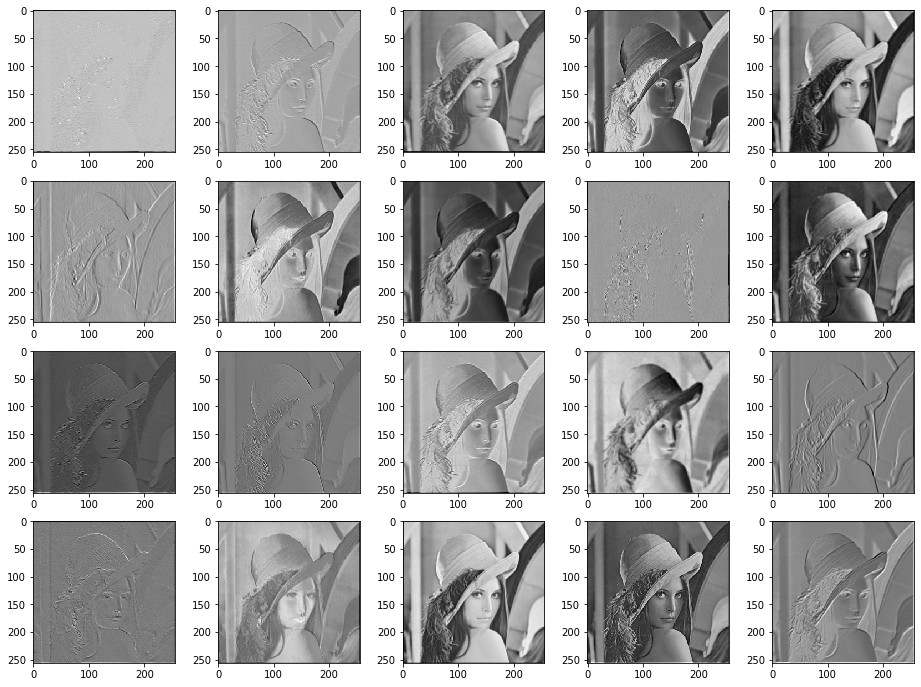

In [26]:
out = conv_layer(img)
f, ax = plt.subplots(4, 5, figsize=(16, 12))
for i, c in enumerate(out[0][:20]):
    ax[i//5][i%5].imshow(c.detach(), cmap='gray')
plt.show()

These kernels were not set by hand, so in a way, they could have "chosen" what they should do, and we can observe a variety of "operations". There are some reminding of gradients, some color mixing, a "negative" image, desaturisation, etc.

Each of these channels will be the input into the next convolutional layers, and will give kernels of that layer a variety of information to work with.

The architecture of ResNet18 gets a bit more complicated at this point, but without explaining too much we shall peek at a few more interesing stages.

The next one will be the first activation layer. Activation introduces non-linearity into models, but for a more plain explanation it selects the important parts of information, i.e. which neurons will be activated. 

In [27]:
activation_layer = torch.nn.Sequential(resnet18.conv1, resnet18.bn1, resnet18.relu)
activation_layer

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)

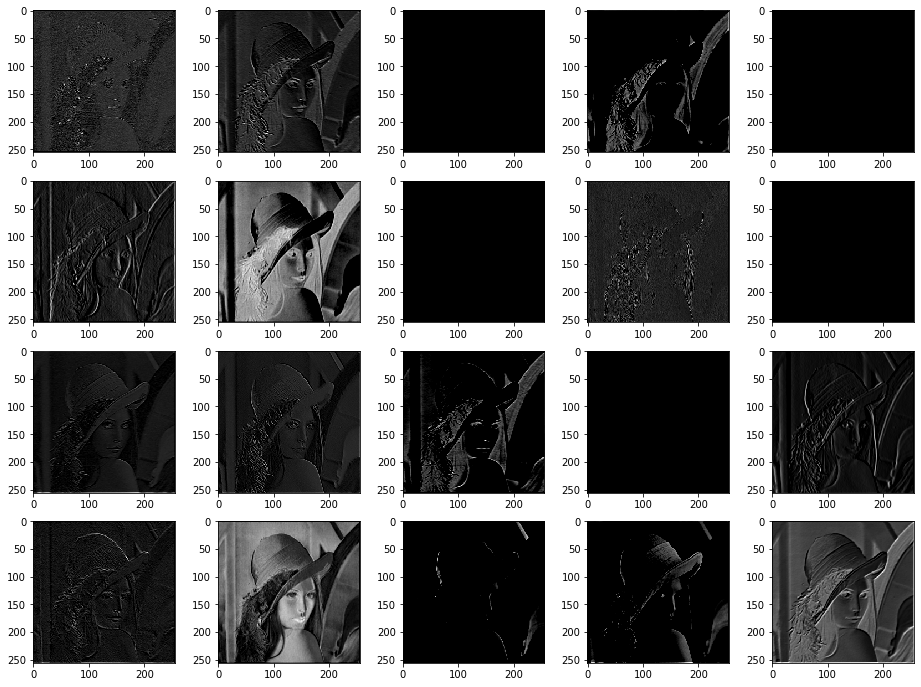

In [28]:
out = activation_layer(img)
f, ax = plt.subplots(4, 5, figsize=(16, 12))
for i, c in enumerate(out[0][:20]):
    ax[i//5][i%5].imshow(c.detach(), cmap='gray')
plt.show()

After the activation we can try to infer what each channel tries to recognize in the original image.

Lets have a look at what happens after few more convolution layers.

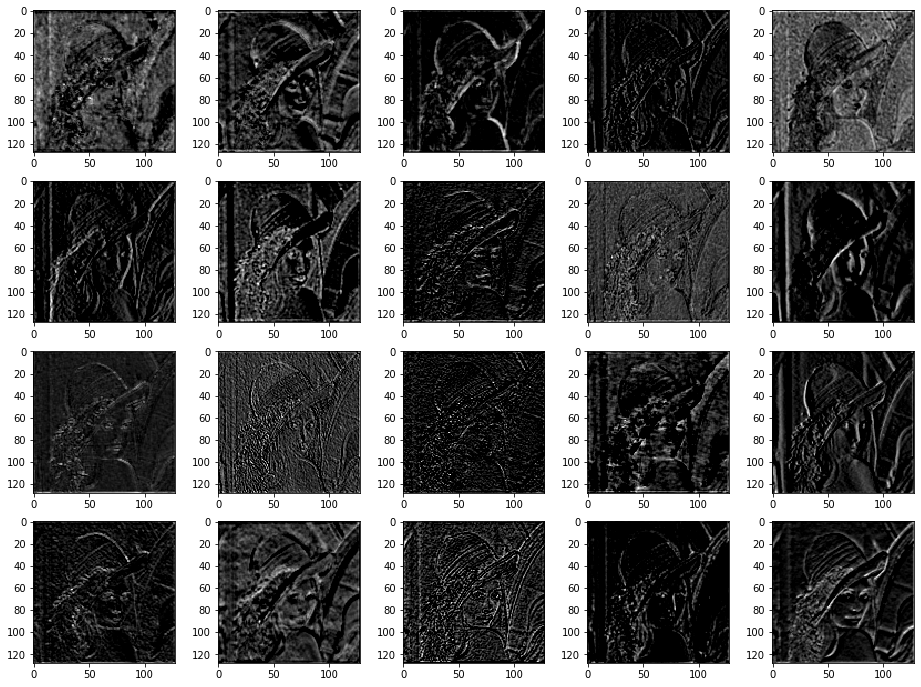

In [29]:
layer = torch.nn.Sequential(resnet18.conv1, resnet18.bn1, resnet18.relu, resnet18.maxpool,
                            resnet18.layer1)
out = layer(img)
f, ax = plt.subplots(4, 5, figsize=(16, 12))
for i, c in enumerate(out[0][:20]):
    ax[i//5][i%5].imshow(c.detach(), cmap='gray')
plt.show()

And a few more...

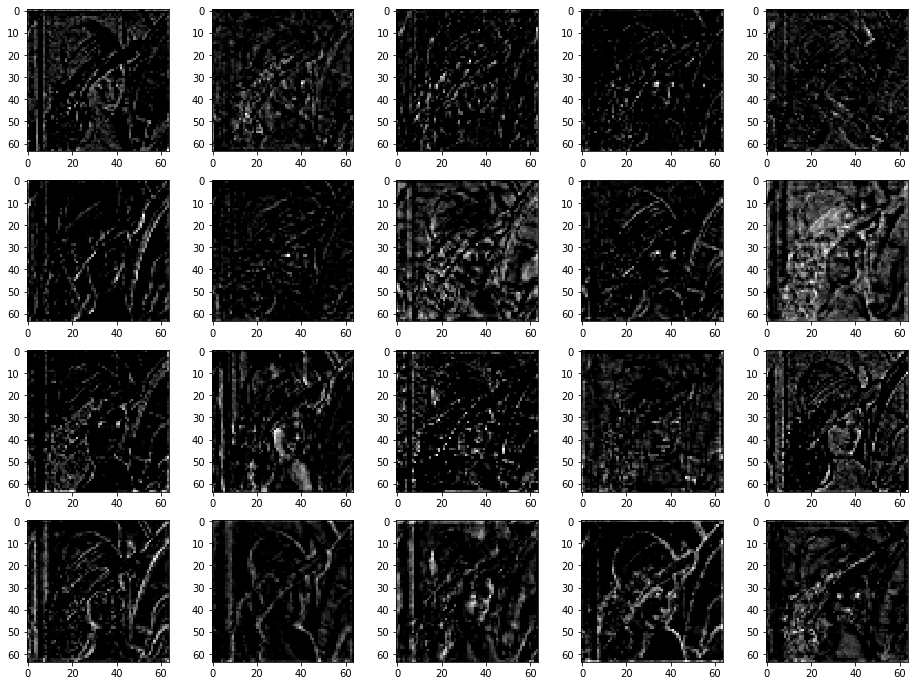

In [30]:
layer = torch.nn.Sequential(resnet18.conv1, resnet18.bn1, resnet18.relu, resnet18.maxpool,
                            resnet18.layer1, resnet18.layer2)
out = layer(img)
f, ax = plt.subplots(4, 5, figsize=(16, 12))
for i, c in enumerate(out[0][:20]):
    ax[i//5][i%5].imshow(c.detach(), cmap='gray')
plt.show()

And lets skip to the final one.

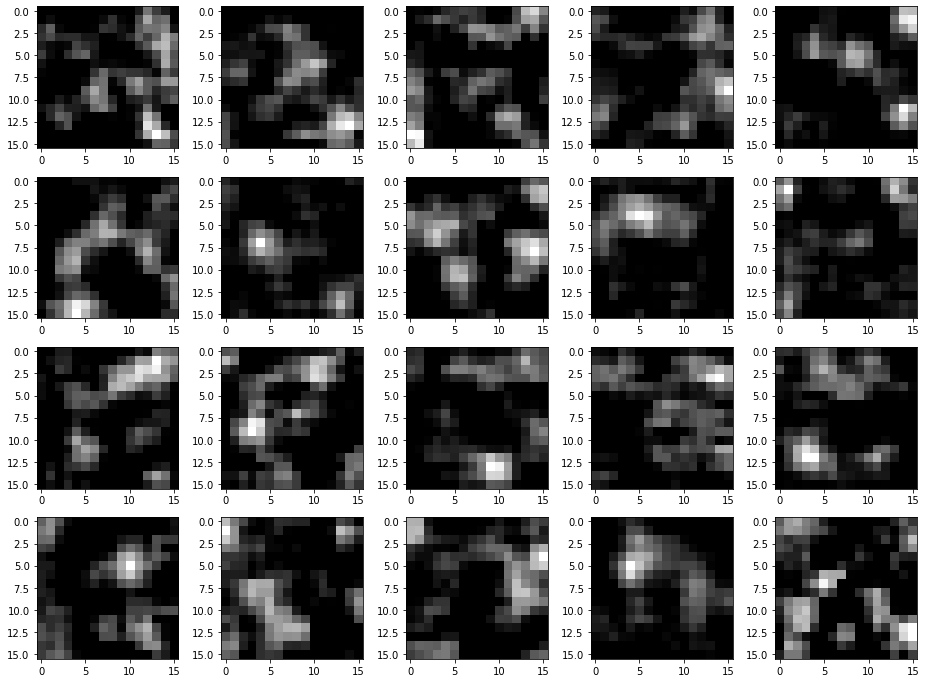

In [31]:
layer = torch.nn.Sequential(resnet18.conv1, resnet18.bn1, resnet18.relu, resnet18.maxpool,
                            resnet18.layer1, resnet18.layer2, resnet18.layer3, resnet18.layer4)
out = layer(img)
f, ax = plt.subplots(4, 5, figsize=(16, 12))
for i, c in enumerate(out[0][:20]):
    ax[i//5][i%5].imshow(c.detach(), cmap='gray')
plt.show()

The spatial information, or form that humans could interpret is long gone at this point, but there are many channels, 512 to be exact. At this point neural networks discard the notion of width and heights and work simply with neurons. This model will average the values in each of 512 channels, and simply have 512 values going forward in its classification task.

### Conclusion

This was a very quick introduction to the mechanics behind computer vision.

We introduced the convolution operation on an image, and showed various things that can be achieved with them.

We extended the notion of image channels from Red, Green and Blue, to a more general form where a varying amount of channels can contain various information about the image.

Finally, we combined those concepts in the architecture of convolutional neural networks where repeated application of convolutional operations processes the image from a visualy spatial form to a more abstract value vector form.